In [2]:
import kaleido
import plotly.express as px
import matplotlib.ticker as mticker

In [3]:
import os
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt

In [5]:
import shap

C:\Users\kdahal3.ASURITE\.conda\envs\SLR\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import pandas as pd
data = pd.read_csv("GW_v3.csv") 
data.drop(["system:index", ".geo"], axis=1, inplace=True)

In [7]:
x = data.drop(["presence"],axis=1)
y = data["presence"]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

In [8]:
data

,Aspect,Eastness,Elevation,GaussianCurvature,HAND,Hillshade,HorizontalCurvature,MaximalCurvature,MeanCurvature,MinimalCurvature,Northness,PRCPTOT,ShapeIndex,Slope,TPI,VerticalCurvature,lineament,presence
0,127.497713,0.793378,1494.704575,-9.869021e-07,613.43445,0.759099,-0.000607,0.000634,-0.000462,-0.001557,-0.608730,1258.3375,-0.268382,40.679466,127,-0.000316,0.541201,1
1,39.131004,0.631096,1122.837176,3.817523e-08,335.23517,0.830249,-0.000983,-0.000038,-0.000524,-0.001010,0.775705,1258.3375,-0.686094,34.047426,-1,-0.000065,0.832848,1
2,15.686834,0.270379,2036.524648,-5.590145e-07,114.29387,0.828289,-0.000504,0.000722,-0.000026,-0.000775,0.962754,1258.3375,-0.022437,34.210240,-60,0.000452,0.749804,1
3,208.080706,-0.470715,2106.038249,-2.512453e-06,466.65690,0.739287,0.000371,0.002123,0.000470,-0.001183,-0.882285,1251.1565,0.181022,42.172060,58,0.000569,0.792028,1
4,221.743194,-0.665793,1463.392820,2.710645e-06,94.56001,0.895170,0.002645,0.003822,0.002266,0.000709,-0.746136,1258.3375,0.926703,26.295283,-131,0.001886,1.101466,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,5.768753,0.100514,1124.548379,1.658860e-07,256.45870,0.917266,0.000581,0.000513,0.000418,0.000323,0.994936,1353.4120,2.808188,23.580560,61,0.000255,0.918776,1
5404,165.344505,0.253007,2148.813331,-1.079904e-06,193.93234,0.586958,0.000355,0.000947,-0.000097,-0.001140,-0.967465,1251.1565,-0.058953,54.005111,-134,-0.000548,1.142460,1
5405,208.992774,-0.484699,1285.240106,-4.683780e-06,262.29830,0.972737,0.004885,0.005548,0.002352,-0.000844,-0.874681,1353.4120,0.468485,13.250726,62,-0.000181,0.879827,1
5406,229.911521,-0.765051,1558.755453,-1.453858e-06,294.50116,0.930105,-0.001374,0.000995,-0.000233,-0.001461,-0.643970,1353.4120,-0.120869,21.368916,77,0.000908,0.976497,1


In [9]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def auc(label, pred, scaler=None):
    return roc_auc_score(label, pred)

get_metric = metric_wrapper(auc, None)

def data_loader(data, random_state):
    task_type = "Classification"
    x_name = list(data.drop(["presence"], axis=1).columns)
    meta_info = {x_name[i]:{'type':'continuous'} for i in range(len(x_name))}
    meta_info.update({'presence':{'type':'target'}}) 

    x, y = data.iloc[:,:-1].values, data.iloc[:,[-1]].values
    xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            enc = OrdinalEncoder()
            enc.fit(y)
            y = enc.transform(y)
            meta_info[key]['values'] = enc.categories_[0].tolist()
        else:
            sx = MinMaxScaler((0, 1))
            xx[:,[i]] = sx.fit_transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(auc, None)

In [10]:
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_loader(data,1)

In [11]:
%%capture
#Activation fuction - Rectified linear activation function

gaminet = GAMINet(meta_info=meta_info, interact_num=20, 
                interact_arch=[60] * 5, subnet_arch=[60] * 5, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[100, 100, 100],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                verbose=True, val_ratio=0.2, random_state=1)
gaminet.fit(train_x, train_y)

In [11]:
%%capture

import pickle

# save the model using pickle
with open('gaminet_model.pickle', 'wb') as f:
    pickle.dump(gaminet, f)


In [12]:
pred_train = gaminet.predict(train_x)
pred_test = gaminet.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train),5), 
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[0.91144 0.8901 ]


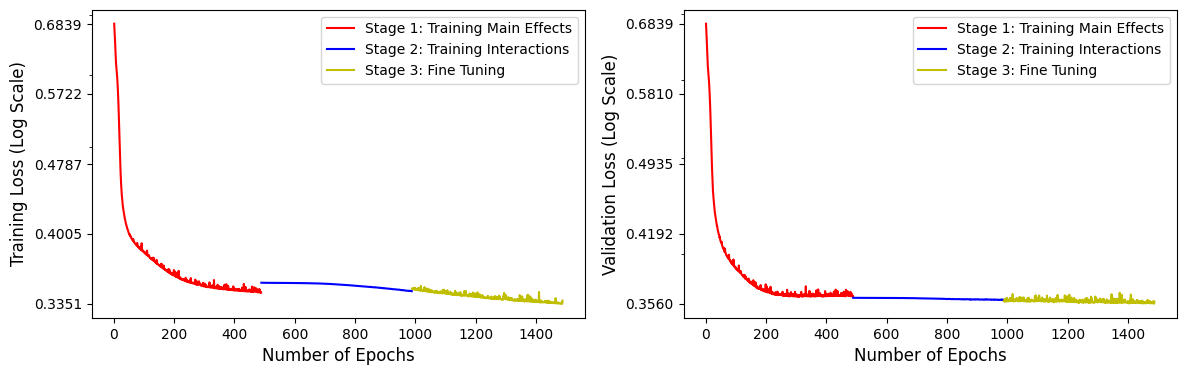

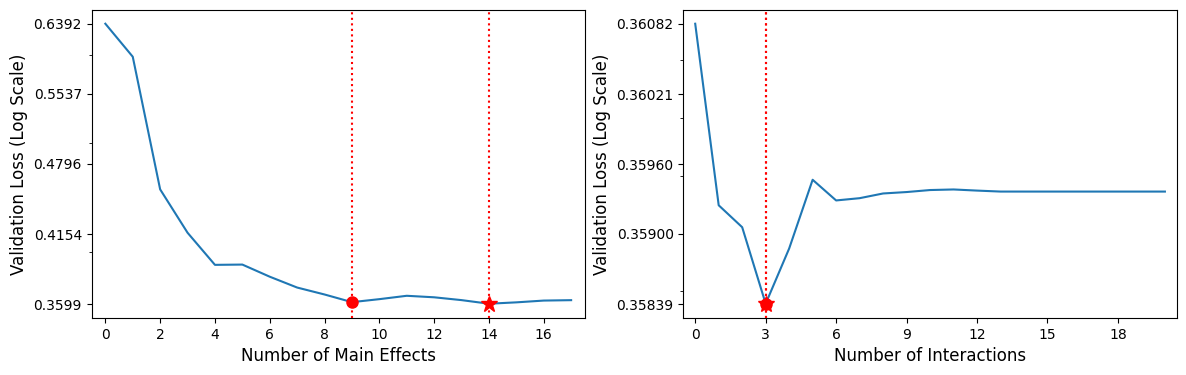

In [13]:

data_dict_logs = gaminet.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, name="ch_traj")
plot_regularization(data_dict_logs, name="ch_regu")


In [14]:
gaminet.predict(test_x)

array([[0.82709694],
       [0.8388112 ],
       [0.33461237],
       ...,
       [0.47821715],
       [0.9247771 ],
       [0.8724763 ]], dtype=float32)

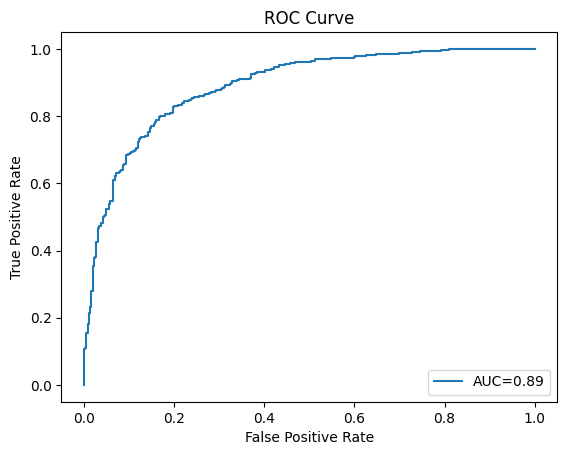

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score
y_pred_proba = gaminet.predict(test_x)
fpr, tpr, _ = metrics.roc_curve(test_y, y_pred_proba)
auc = metrics.roc_auc_score(test_y, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label="AUC={:.2f}".format(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc=4)
plt.show()


# GAMI-Net

### GAMI-net main paper
https://arxiv.org/pdf/2003.07132.pdf

https://datascience.stackexchange.com/questions/73553/how-is-the-base-value-of-shap-values-calculated

# Model-Agnostic Explainer for GAMINET

### SHAP for Global Behaviour

In [19]:
masker = shap.maskers.Independent(data = test_x)
explainer = shap.Explainer(gaminet, masker = masker)
shap_values = explainer(test_x)

Permutation explainer: 1083it [1:02:09,  3.45s/it]                                                                     


In [81]:
import pickle as pickle

with open('shap_values_gam.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [ ]:
with open('shap_values_gam.pkl', 'rb') as f:
    shap_values_loaded = pickle.load(f)

In [82]:
feature_names = list(meta_info.keys())

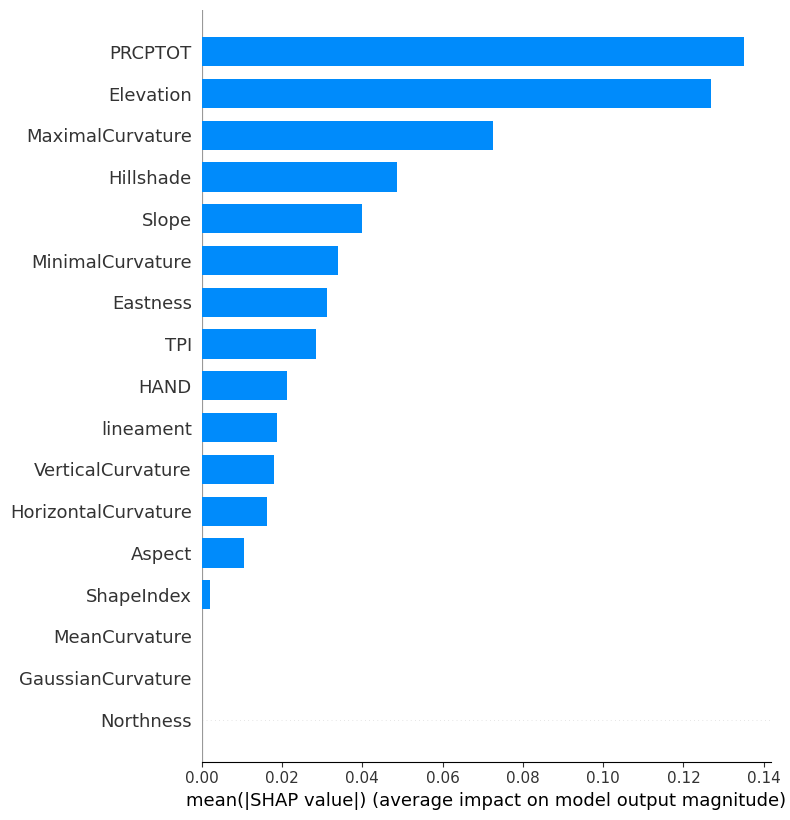

In [83]:
shap.summary_plot(shap_values, test_x, feature_names=feature_names, plot_type="bar", show=True)

# plt.savefig(".\Gami_net_graphs\summary_plot_GAMInet.png")

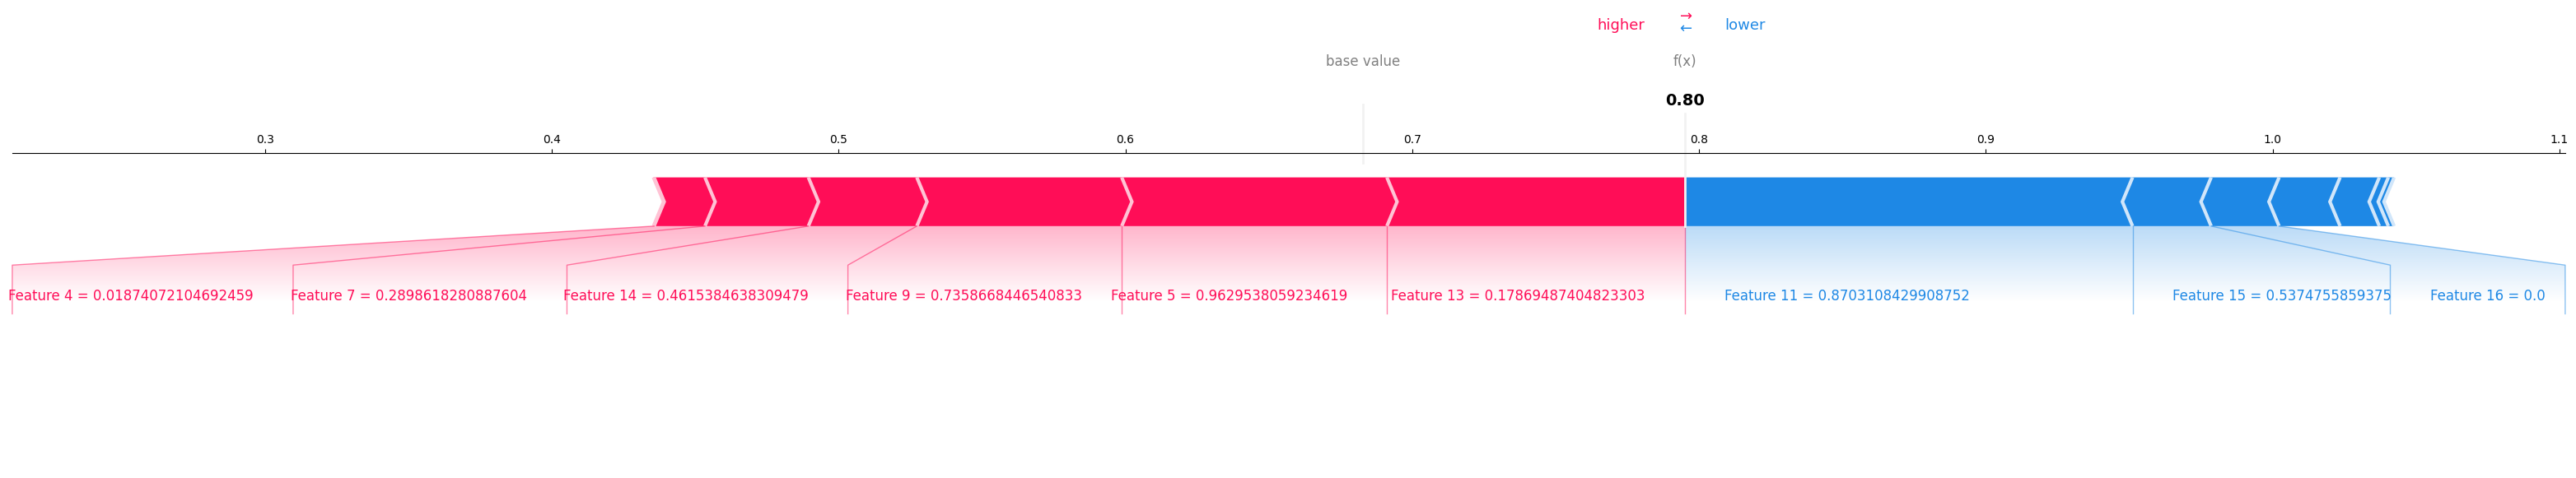

In [57]:
# visualize the first prediction's explanation
i = 0
shap.force_plot(shap_values[1], matplotlib=True, figsize=(40,5))
# plt.savefig(".\Gami_net_graphs\Waterfall_.png", dpi=600, bbox_inches='tight')

In [58]:
shap.initjs()
# shap.force_plot(shap_values.base_values[0], shap_values)

# Intrinsic Interpretability

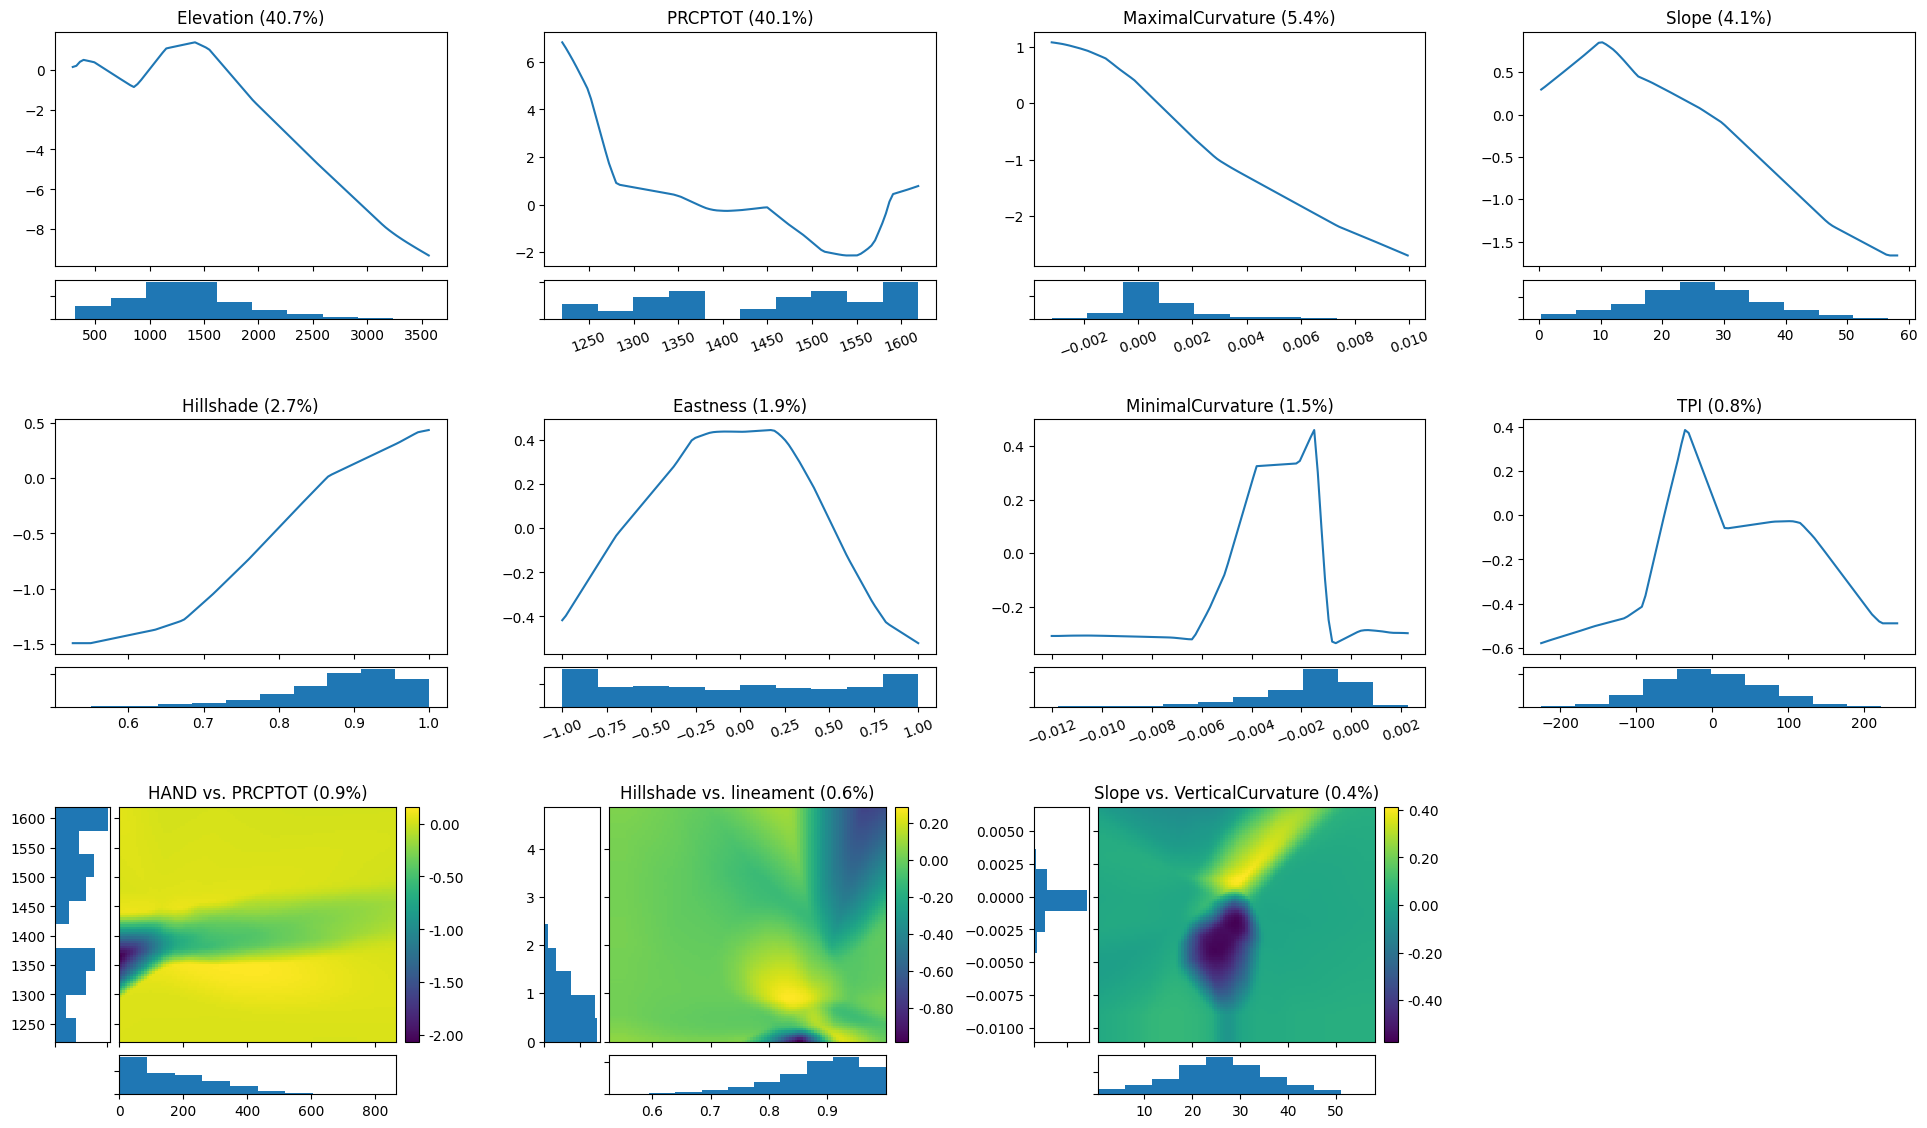

In [17]:
data_dict_global = gaminet.global_explain(save_dict=True, name="ch_global")
global_visualize_density(data_dict_global, name="ch_global",
                         main_effect_num=8, interaction_num=4, cols_per_row=4, save_png=True, save_eps=True)

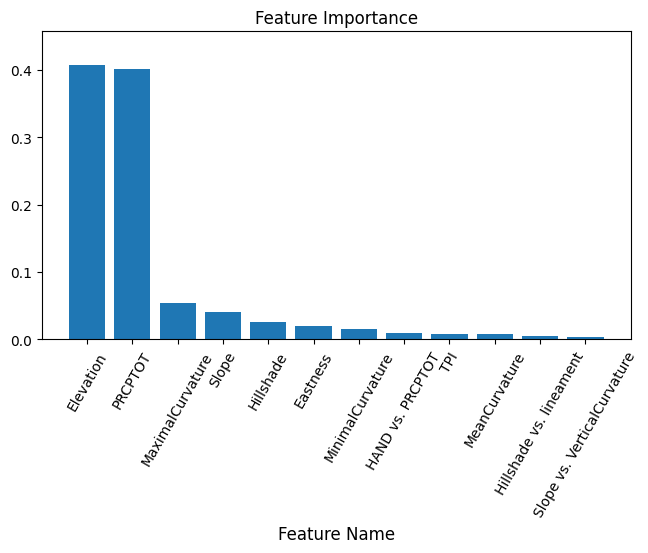

In [18]:
feature_importance_visualize(data_dict_global)

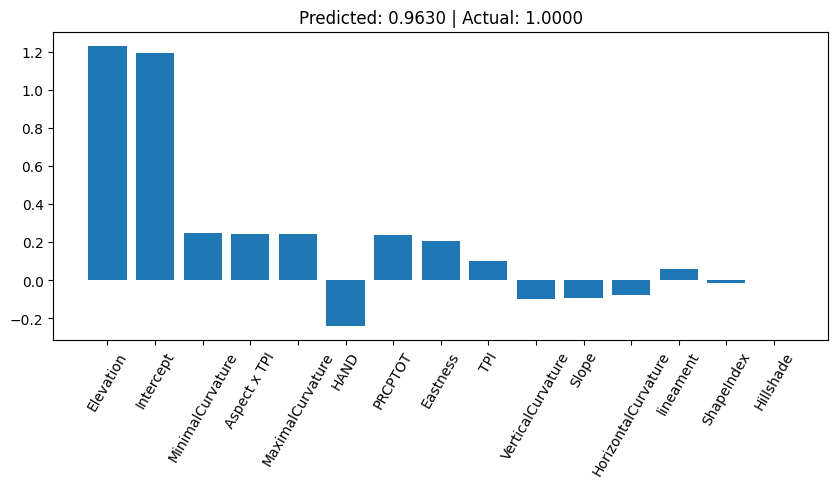

In [63]:
data_dict_local = gaminet.local_explain(test_x[[5]], test_y[[5]], save_dict=False)
local_visualize(data_dict_local[0], save_png=False)

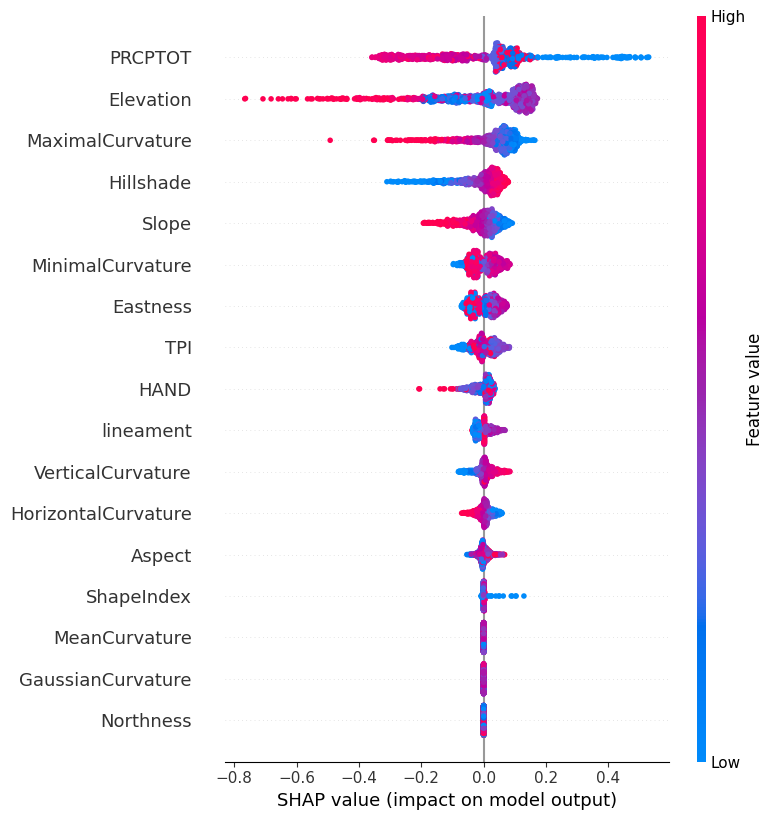

In [88]:
shap.summary_plot(shap_values, test_x, feature_names = feature_names)

In [20]:
import rasterio
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the raster dataset stack using rasterio
with rasterio.open('pred/parameters_100.tif') as src:
    stack = src.read()

# Reshape the stack to a 2D array (n_samples, n_features)
stack_2d = stack.reshape(stack.shape[0], -1).T

# Convert the 2D array to a pandas DataFrame
df = pd.DataFrame(data=stack_2d)

# Normalize the features using the same scaler that was used to train the GAMINet model
scaler = StandardScaler()
X = scaler.fit_transform(df)

# Use the GAMINet model to predict the values for each pixel in the raster stack
y_pred = gaminet.predict(X)

# Reshape the probabilities to match the original raster shape
y_pred_proba = y_pred.reshape(stack.shape[1], stack.shape[2])

# Save the predicted probabilities as a new raster using rasterio
with rasterio.open('pred/predicted_gam.tiff', 'w', **src.meta) as dst:
    dst.write(y_pred_proba, 1)


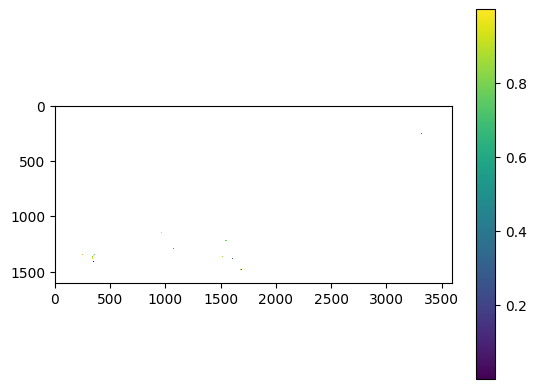

In [21]:
import matplotlib.pyplot as plt
plt.imshow(y_pred_proba)
plt.colorbar()
plt.show()


In [25]:
print("Minimum probability:", np.amin(y_pred_proba))
print("Maximum probability:", np.amax(y_pred_proba))
print("Mean probability:", np.mean(y_pred_proba))
print("Median probability:", np.median(y_pred_proba))
print("Standard deviation of probabilities:", np.std(y_pred_proba))


Minimum probability: nan
Maximum probability: nan
Mean probability: nan
Median probability: nan
Standard deviation of probabilities: nan


C:\Users\kdahal3.ASURITE\AppData\Local\Temp\ipykernel_12772\2916343875.py:30: RuntimeWarning:

overflow encountered in multiply



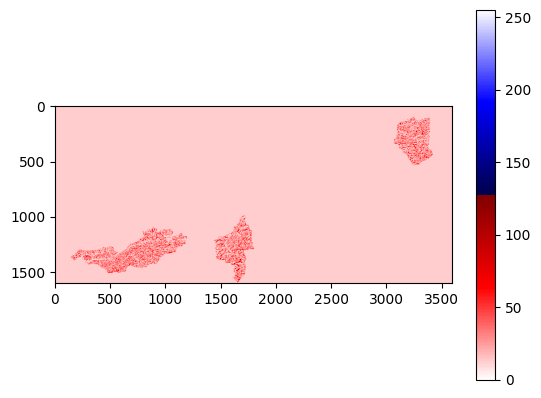

In [115]:
import rasterio
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Define the red-to-yellow and blue colormap
ryb = plt.get_cmap('seismic')
red_yellow = ryb(np.linspace(0.5, 1, 128))
blue = ryb(np.linspace(0, 0.5, 128))
ryb = ListedColormap(np.concatenate((red_yellow, blue)))

# Open the GeoTIFF file
with rasterio.open('pred/predicted_gam.tiff') as src:
    # Read the first band of the raster
    band = src.read(1)
    
    # Remove NaN values
    band = np.nan_to_num(band, nan=-9999)
    
    # Get the data range and adjust it to a suitable range
    vmin, vmax = np.percentile(band, (1, 99))
    range_ = vmax - vmin
    vmin -= range_ * 0.05
    vmax += range_ * 0.05
    
    # Calculate a suitable scaling factor
    scale_factor = 255 / range_
    
    # Rescale the data to 0-255 range
    band = (band - vmin) * scale_factor
    
    # Convert the data to uint8 type
    band = band.astype(np.uint8)

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(band, cmap=ryb, vmin=0, vmax=255)
plt.colorbar(im)

# Show the plot
plt.show()
